In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
from tqdm import tqdm
from scipy import stats
import networkx as nx
import seaborn as sns
import re
import sys
sys.path.append("../scripts/")
from ner_eval_all_experiments import *

plt.style.use("../config/custom_plt.mplstyle")

plt.rc('text', usetex=False)

/home/rjankow/repo/embedding-neural-networks/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%%time

results_classifier, results_pos_enc, results_l1_first, results_l2_first, results_l1_last, results_l2_last = evaluate_ner_task()


Shuffling:   0%|          | 0/2 [00:00<?, ?it/s]


Shuffling: 100%|██████████| 2/2 [06:47<00:00, 203.79s/it]


Shuffling:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
results_list = [
    (results_classifier, 'Classifier'),
    (results_pos_enc,    'Positional Encoding'),
    (results_l1_first,   'L1 First Transformer Block'),
    (results_l2_first,   'L2 First Transformer Block'),
    (results_l1_last,    'L1 Last Transformer Block'),
    (results_l2_last,    'L2 Last Transformer Block'),
]

In [ ]:
# import pickle
# with open('distilbert_results_list_17_06.pickle', 'wb') as f:
#     pickle.dump(results_list, f)


In [8]:
dataset = load_dataset("conll2003")

model_name = "dslim/distilbert-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenized_datasets = dataset["test"].map(
    lambda x: tokenize_and_align_labels(x, tokenizer), batched=True
)

columns_to_remove = ["id", "tokens", "pos_tags", "chunk_tags", "ner_tags"]
tokenized_datasets = tokenized_datasets.remove_columns(columns_to_remove)

data_collator = DataCollatorForTokenClassification(tokenizer)
eval_dataloader = DataLoader(
    tokenized_datasets, collate_fn=data_collator, batch_size=16
)
label_list = dataset["train"].features["ner_tags"].feature.names

base = AutoModelForTokenClassification.from_pretrained(model_name)


layer_weights = {
    'Classifier': torch.std(base.classifier.weight.data.clone().flatten()),
    'Positional Encoding': torch.std(base.distilbert.embeddings.position_embeddings.weight.data.clone().flatten()),
    'L1 First Transformer Block': torch.std(base.distilbert.transformer.layer[0].ffn.lin1.weight.data.clone().flatten()),
    'L2 First Transformer Block': torch.std(base.distilbert.transformer.layer[0].ffn.lin2.weight.data.clone().flatten()),
    'L1 Last Transformer Block': torch.std(base.distilbert.transformer.layer[5].ffn.lin1.weight.data.clone().flatten()),
    'L2 Last Transformer Block': torch.std(base.distilbert.transformer.layer[5].ffn.lin2.weight.data.clone().flatten()),
}

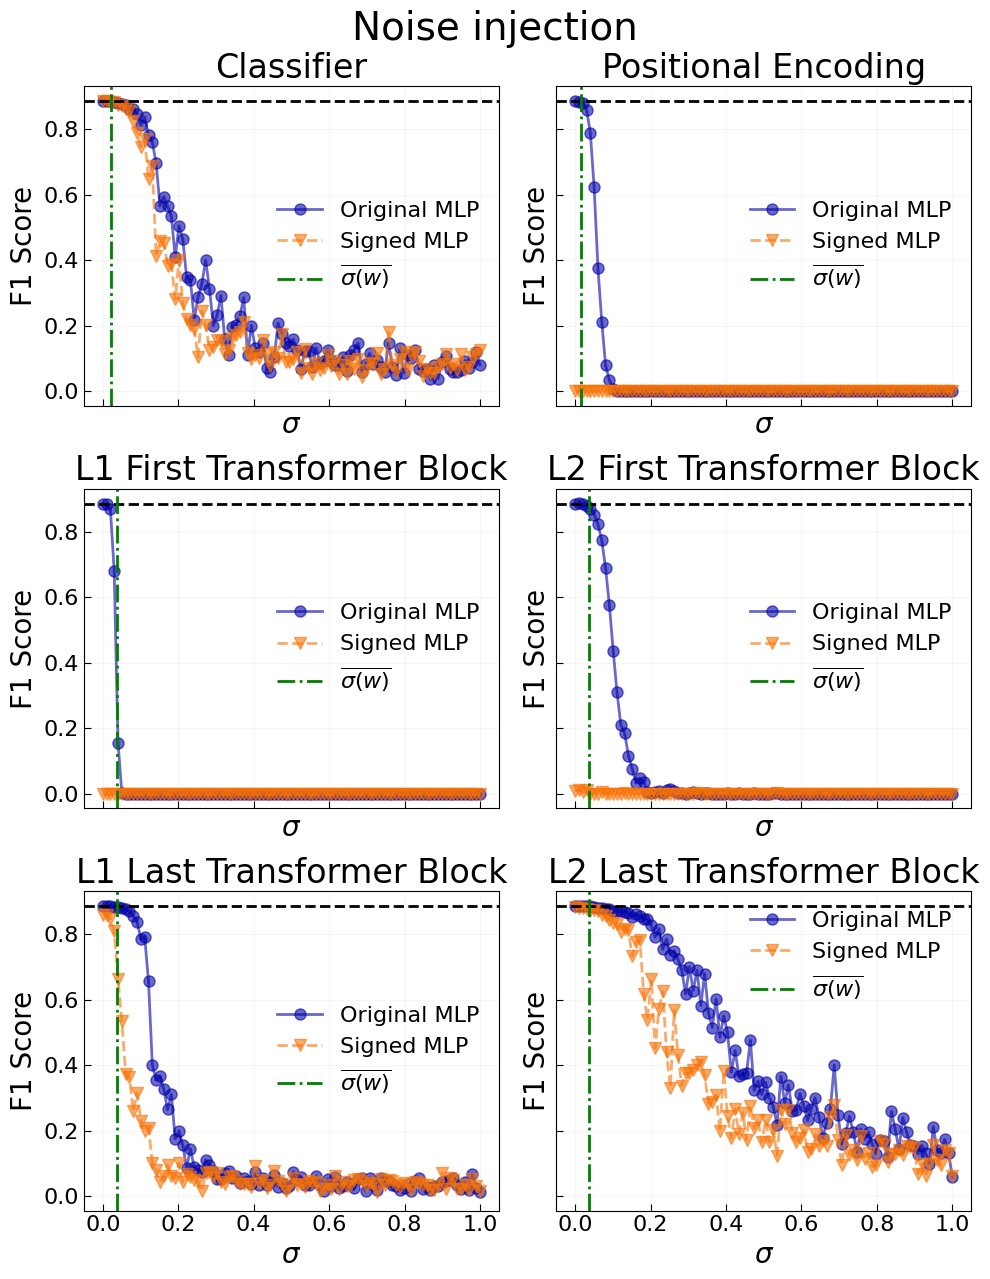

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(10, 13), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (res, title) in zip(axes, results_list):
    # Extract the lists
    sigmas  = [r['sigma']   for r in res['noise']]
    flt_f1  = [float(r['flt_f1']) for r in res['noise']]
    bin_f1  = [float(r['bin_f1']) for r in res['noise']]
    
    # Plot lines and baseline
    ax.plot(sigmas, flt_f1, 'o-',  label='Original MLP', color='xkcd:royal blue', alpha=0.6)
    ax.plot(sigmas, bin_f1, 'v--', label='Signed MLP',   color='xkcd:orange', alpha=0.6)
    ax.axhline(res['baseline'], color='black', linestyle='--')
    
    ax.axvline(layer_weights[title], linestyle='-.', color='green', label=r'$\overline{\sigma(w)}$')
    
    ax.set_xlabel('$\\sigma$')
    ax.set_ylabel('F1 Score')
    ax.set_title(title)
    ax.legend()

fig.suptitle('Noise injection', fontsize=28)
fig.tight_layout()

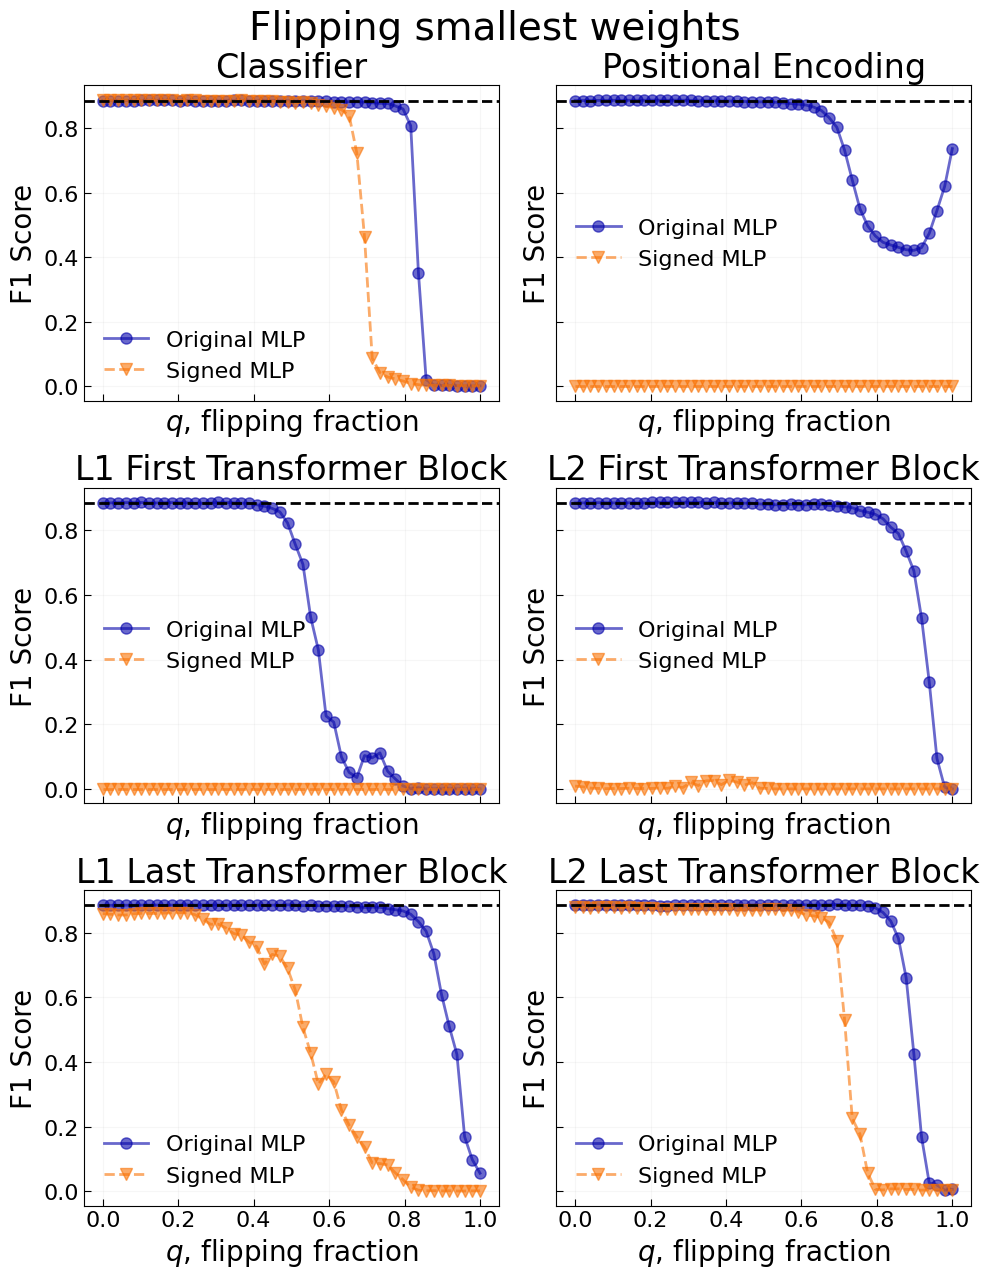

In [10]:
fig, axes = plt.subplots(3, 2, figsize=(10, 13), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (res, title) in zip(axes, results_list):
    # Extract the lists
    sigmas  = [r['q']   for r in res['flip']]
    flt_f1  = [float(r['flt_f1']) for r in res['flip']]
    bin_f1  = [float(r['bin_f1']) for r in res['flip']]
    
    # Plot lines and baseline
    ax.plot(sigmas, flt_f1, 'o-',  label='Original MLP', color='xkcd:royal blue', alpha=0.6)
    ax.plot(sigmas, bin_f1, 'v--', label='Signed MLP',   color='xkcd:orange', alpha=0.6)
    ax.axhline(res['baseline'], color='black', linestyle='--')

    ax.set_xlabel('$q$, flipping fraction')
    ax.set_ylabel('F1 Score')
    ax.set_title(title)
    ax.legend()

fig.suptitle('Flipping smallest weights', fontsize=28)
fig.tight_layout()

In [14]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12), sharex=True, sharey=True)
# axes = axes.flatten()

# i = 0
# for ax, (res, title) in zip(axes, results_list):
#     # Extract the lists
#     sigmas  = [1-r['frac']   for r in res['threshold']]
#     flt_f1  = [float(r['flt_f1']) for r in res['threshold']]
#     bin_f1  = [float(r['bin_f1']) for r in res['threshold']]
    
#     ax.plot(sigmas, flt_f1, linestyle='-',  label='Original', color='xkcd:olive')
#     ax.plot(sigmas, bin_f1, linestyle='--', label='Signed',   color='xkcd:olive')
    
#     flt_f1  = [float(r['shuffle_random_pos_neg_flt_f1']) for r in res['threshold']]
#     bin_f1  = [float(r['shuffle_random_pos_neg_bin_f1']) for r in res['threshold']]
#     ax.plot(sigmas, flt_f1, linestyle='-',  label='Original + Shuffle B', color='xkcd:purple')
#     ax.plot(sigmas, bin_f1, linestyle='--', label='Signed + Shuffle B',   color='xkcd:purple')

#     flt_f1  = [float(r['shuffle_random_flt_f1']) for r in res['threshold']]
#     bin_f1  = [float(r['shuffle_random_bin_f1']) for r in res['threshold']]
#     ax.plot(sigmas, flt_f1, linestyle='-',  label='Original + Shuffle A', color='xkcd:blue')
#     ax.plot(sigmas, bin_f1, linestyle='--', label='Signed + Shuffle A',   color='xkcd:blue')

#     ax.axhline(res['baseline'], color='black', linestyle='--')

#     ax.set_xlabel('$p$, fraction of missing edges')
#     ax.set_ylabel('F1 Score')
#     ax.set_title(title)
#     if i == 0:
#         ax.legend()
#     i += 1

# fig.tight_layout()

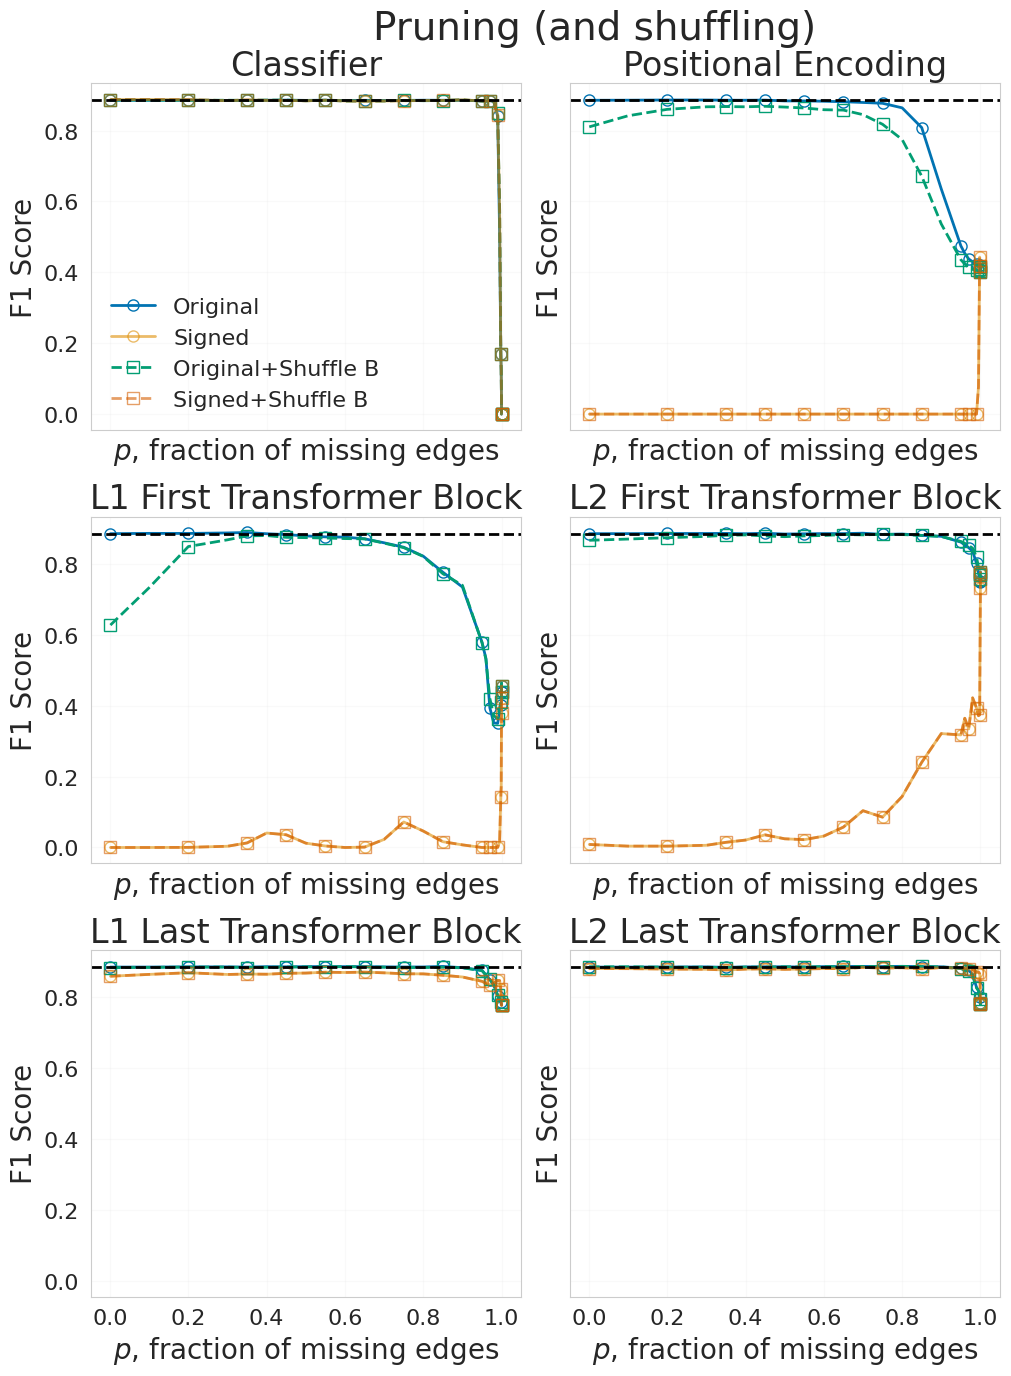

In [12]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('colorblind')

fig, axes = plt.subplots(3, 2, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (res, title) in zip(axes, results_list):
    styles = [('-', 'o'), ('--', 's'), (':', '^')]
    labels = ['Original', 'Signed', 'Original+Shuffle B', 'Signed+Shuffle B', 
              'Original+Shuffle A', 'Signed+Shuffle A']
    keys   = [
        ('flt_f1','bin_f1'),
        ('shuffle_random_pos_neg_flt_f1','shuffle_random_pos_neg_bin_f1'),
        #('shuffle_random_flt_f1','shuffle_random_bin_f1'),
    ]
    
    i = 0
    for (flt_key, bin_key), (ls, mk) in zip(keys, styles):
        sigmas = [1-r['frac'] for r in res['threshold']]
        y_flt  = [float(r[flt_key]) for r in res['threshold']]
        y_bin  = [float(r[bin_key]) for r in res['threshold']]
        ax.plot(sigmas, y_flt,  linestyle=ls, linewidth=2, marker=mk, markevery=2, label=labels[i],
               markerfacecolor='none')
        ax.plot(sigmas, y_bin,  linestyle=ls, linewidth=2, marker=mk, markevery=2, alpha=0.6, label=labels[i+1],
               markerfacecolor='none')
        i += 2
        
    ax.axhline(res['baseline'], color='black', linestyle='--')
    ax.set_xlabel('$p$, fraction of missing edges')
    ax.set_ylabel('F1 Score')
    ax.set_title(title)

axes[0].legend()
fig.suptitle('Pruning (and shuffling)', fontsize=28)
fig.tight_layout(rect=[0,0,0.85,1])
plt.show()


In [88]:
results_list_new = [
    (results_pos_enc,    'Positional Encoding'),
    (results_l1_first,   'L1 First Transformer Block'),
    (results_l2_first,   'L2 First Transformer Block'),
    (results_l1_last,    'L1 Last Transformer Block'),
    (results_l2_last,    'L2 Last Transformer Block'),
    (results_classifier, 'Classifier'),
]

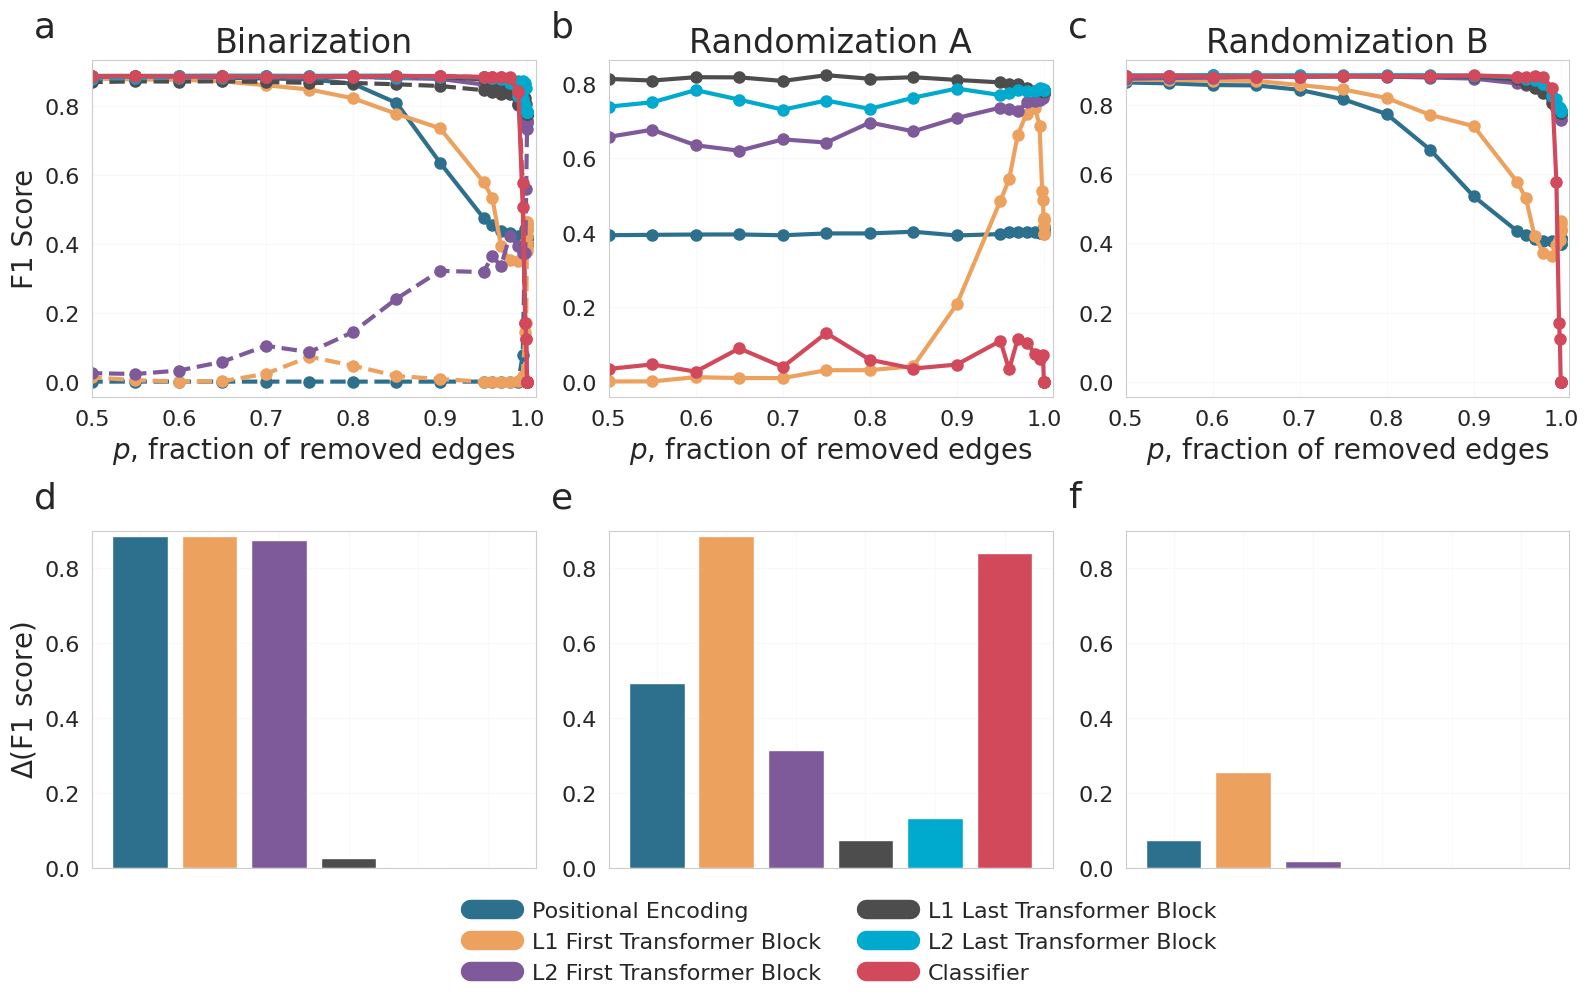

In [160]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

layer_colors = ['#2D708E','#EDA15F','#7E5A9B','#4D4D4D','#00A9CE','#D1495B']

i = 0
for r in results_list_new:
    x = [1-x['frac'] for x in r[0]['threshold']]
    y1 = [x['flt_f1'] for x in r[0]['threshold']]
    y2 = [x['bin_f1'] for x in r[0]['threshold']]
    axes[0, 0].plot(x, y1, marker='o', color=layer_colors[i], linestyle='-', linewidth=3)
    axes[0, 0].plot(x, y2, marker='o', color=layer_colors[i], linestyle='--', linewidth=3)
    i += 1
axes[0, 0].set_xlim(0.5, 1.01)
axes[0, 0].set_title('Binarization')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].set_xlabel('$p$, fraction of removed edges')

i = 0
for r in results_list_new:
    x = [1-x['frac'] for x in r[0]['threshold']]
    y1 = [x['shuffle_random_flt_f1'] for x in r[0]['threshold']]
    y2 = [x['shuffle_random_bin_f1'] for x in r[0]['threshold']]
    axes[0, 1].plot(x, y1, marker='o', color=layer_colors[i], linestyle='-', linewidth=3)
    #axes[0, 1].plot(x, y2, marker='o', color=layer_colors[i], linestyle='--', linewidth=3)
    i += 1
axes[0, 1].set_xlim(0.5, 1.01)
axes[0, 1].set_title('Randomization A')
axes[0, 1].set_xlabel('$p$, fraction of removed edges')

i = 0
for r in results_list_new:
    x = [1-x['frac'] for x in r[0]['threshold']]
    y1 = [x['shuffle_random_pos_neg_flt_f1'] for x in r[0]['threshold']]
    y2 = [x['shuffle_random_pos_neg_bin_f1'] for x in r[0]['threshold']]
    axes[0, 2].plot(x, y1, marker='o', color=layer_colors[i], linestyle='-', linewidth=3)
    #axes[0, 2].plot(x, y2, marker='o', color=layer_colors[i], linestyle='--', linewidth=3)
    i += 1
axes[0, 2].set_xlim(0.5, 1.01)
axes[0, 2].set_title('Randomization B')
axes[0, 2].set_xlabel('$p$, fraction of removed edges')


all_names = []
all_acc_diff = []
for r in results_list_new:
    val = r[0]
    all_acc_diff.append(val['threshold'][0]['flt_f1'] - val['threshold'][0]['bin_f1'])
    all_names.append(r[1])
axes[1,0].bar(all_names, all_acc_diff, color=layer_colors)
axes[1,0].set_xticklabels([])
axes[1,0].set_ylabel(r'$\Delta$(F1 score)')
axes[1,0].set_ylim([0, 0.9])

all_names = []
all_acc_diff = []
for r in results_list_new:
    val = r[0]
    all_acc_diff.append(val['threshold'][0]['flt_f1'] - val['threshold'][0]['shuffle_random_flt_f1'])
    all_names.append(r[1])
axes[1,1].bar(all_names, all_acc_diff, color=layer_colors)
axes[1,1].set_xticklabels([])
axes[1,1].set_ylim([0, 0.9])

all_names = []
all_acc_diff = []
for r in results_list_new:
    val = r[0]
    all_acc_diff.append(val['threshold'][0]['flt_f1'] - val['threshold'][0]['shuffle_random_pos_neg_flt_f1'])
    all_names.append(r[1])
axes[1,2].bar(all_names, all_acc_diff, color=layer_colors)
axes[1,2].set_xticklabels([])
axes[1,2].set_ylim([0, 0.9])

subplot_labels = list('abcdef')
for ax, label in zip(axes.flatten(), subplot_labels):
    ax.text(
        -0.13, 1.05, label,            # position: just above top-left of each subplot
        transform=ax.transAxes,         # use axes-relative coordinates
        fontsize=26,
        fontweight='normal',
        va='bottom',
        ha='left'
    )
    
fig.legend(
    handles=[plt.Line2D([0], [0], color=c, lw=14) for c in layer_colors],
    labels=all_names,
    loc='lower center',
    bbox_to_anchor=(0.53, -0.12),
    ncol=2,
    frameon=False
)

plt.tight_layout()

# plt.savefig("../plots/paper/distilbert_main.pdf")

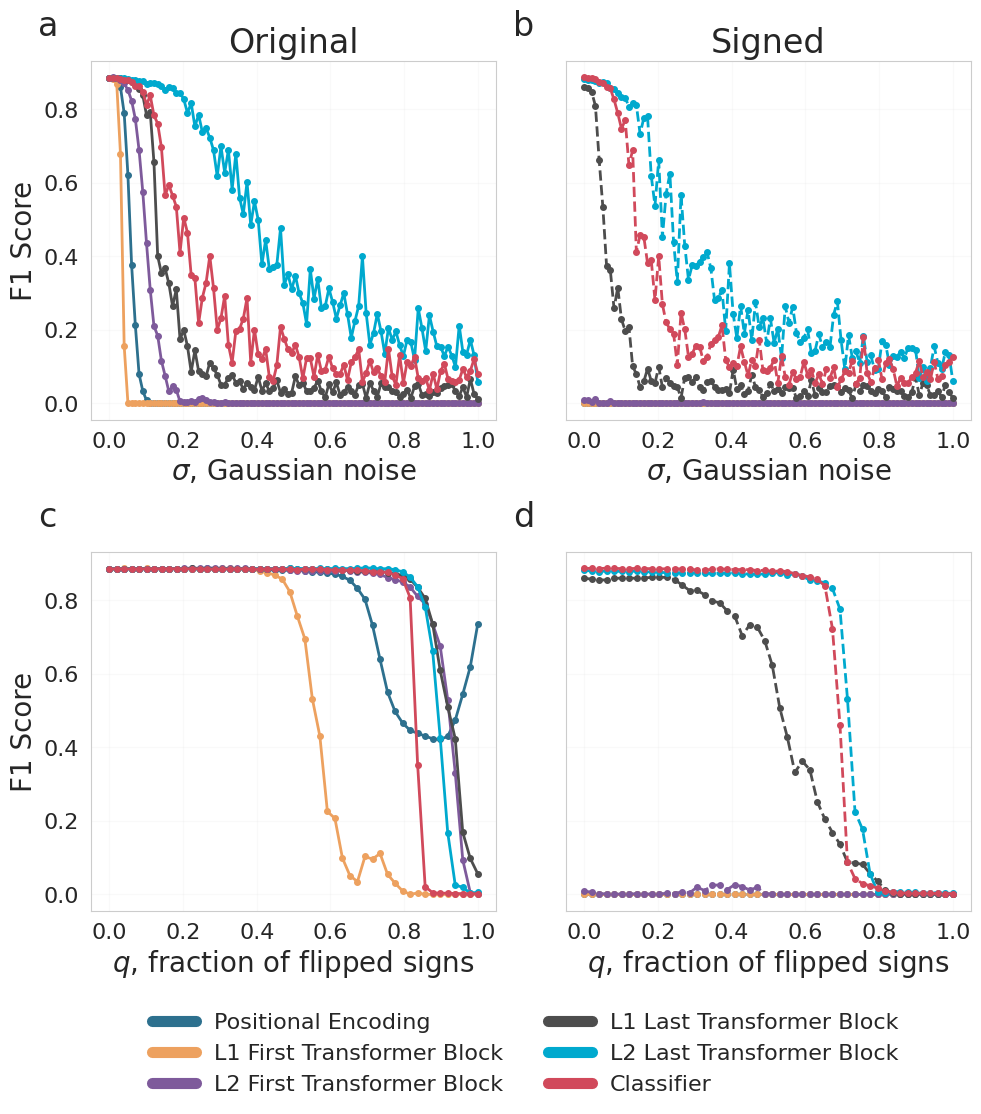

In [158]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

layer_colors = ['#2D708E','#EDA15F','#7E5A9B','#4D4D4D','#00A9CE','#D1495B']

i = 0
for r in results_list_new:
    x = [x['sigma'] for x in r[0]['noise']]
    y1 = [x['flt_f1'] for x in r[0]['noise']]
    y2 = [x['bin_f1'] for x in r[0]['noise']]
    axes[0, 0].plot(x, y1, marker='.', color=layer_colors[i], linestyle='-', linewidth=2)
    axes[0, 1].plot(x, y2, marker='.', color=layer_colors[i], linestyle='--', linewidth=2)
    i += 1
    
axes[0, 0].set_title('Original')
axes[0, 1].set_title('Signed')
axes[0, 0].set_ylabel('F1 Score')
axes[1, 0].set_ylabel('F1 Score')
axes[0, 0].set_xlabel('$\sigma$, Gaussian noise')
axes[0, 1].set_xlabel('$\sigma$, Gaussian noise')


i = 0
for r in results_list_new:
    x = [x['q'] for x in r[0]['flip']]
    y1 = [x['flt_f1'] for x in r[0]['flip']]
    y2 = [x['bin_f1'] for x in r[0]['flip']]
    axes[1, 0].plot(x, y1, marker='.', color=layer_colors[i], linestyle='-', linewidth=2)
    axes[1, 1].plot(x, y2, marker='.', color=layer_colors[i], linestyle='--', linewidth=2)
    i += 1
    
axes[1, 0].set_xlabel('$q$, fraction of flipped signs')
axes[1, 1].set_xlabel('$q$, fraction of flipped signs')

fig.legend(
    handles=[plt.Line2D([0], [0], color=c, lw=8) for c in layer_colors],
    labels=all_names,
    loc='lower center',
    bbox_to_anchor=(0.53, -0.12),
    ncol=2,
    frameon=False
)

subplot_labels = list('abcd')
for ax, label in zip(axes.flatten(), subplot_labels):
    ax.text(
        -0.13, 1.05, label,            # position: just above top-left of each subplot
        transform=ax.transAxes,         # use axes-relative coordinates
        fontsize=24,
        fontweight='normal',
        va='bottom',
        ha='left'
    )
    
plt.tight_layout()

# plt.savefig("../plots/paper/distilbert_SI.pdf")